#### Lab session 7: Outlier Detection 

## Introduction

The purpose of this lab session is to provide you with an opportunity to gain experience in **outlier detection**, covered in week 9, using common Python libraries.

This session starts with a tutorial that uses examples to introduce you to the practical knowledge that you will need for the corresponding assignment. We highly recommend that you read the following tutorials if you need a gentler introduction to the libraries that we use:
- [Numpy quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html)
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)
- [Matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html)
- [Scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html)



**Outlier detection** is a fundamental aspect of data analysis, where the objective is to identify unusual data points that deviate significantly from the majority of the data. These outliers can be indicative of errors, anomalies, or novel insights in various domains, such as finance, healthcare, and network security. The challenge in outlier detection lies in accurately distinguishing these rare events or observations from the norm, especially in complex datasets. This lab session introduces you to different methodologies of outlier detection, each suited to specific types of data and analysis requirements.

The first method, **parametric outlier detection**, assumes that the data follows a well-known distribution, typically a Gaussian distribution. This approach identifies outliers by looking for observations that do not fit the overall distribution of the data. It's particularly useful when the underlying distribution of the dataset is well understood. For instance, in financial data analysis, daily changes in stock prices can be analyzed for anomalies by assuming they follow a Gaussian distribution. However, this method has limitations when the distribution of data is unknown or complex.

In contrast, **proximity-based** and **classification-based** methods provide alternative approaches. Proximity-based methods, such as the **k-nearest neighbors (k-NN)** algorithm, identify outliers based on the spatial distance of data points from their neighbors. This approach is versatile and effective in datasets where the data distribution is unknown or multidimensional, but it can be computationally demanding. On the other hand, classification-based methods like **One-Class SVM** create a model to describe the 'normal' data and classify points that fall outside this model as outliers. This method is particularly useful in situations where the outliers are not well-represented in the dataset or when dealing with high-dimensional data. Each of these methods offers unique advantages and can be selected based on the specific requirements and characteristics of the dataset at hand.

## 1. Outlier detection using parametric methods 

Parametric outlier detection methods are based on the assumption that the data follows a known distribution, typically a Gaussian distribution. This approach involves identifying data points that deviate significantly from this assumed distribution. By calculating changes in data points (like daily stock price changes in your example) and assuming these changes follow a Gaussian distribution, outliers can be identified as those changes which are statistically improbable. This method is useful in cases where the underlying distribution of the data is well understood and can be accurately modeled.

This approach assumes that the majority of the data instances are governed by some well-known probability distribution, e.g. a Gaussian distribution. Outliers can then be detected by seeking for observations that do not fit the overall distribution of the data. 

In this example, our goal is to detect anomalous changes in the daily closing prices of various stocks. The input data **stocks.csv** (available in the lab supplementary material) contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America). 

In [1]:
import pandas as pd

# Load CSV file, set the 'Date' values as the index of each row, and display the first rows of the dataframe
stocks = pd.read_csv('stocks.csv', header='infer') 
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'],axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [2]:
import numpy as np

N,d = stocks.shape
# Compute delta, which denotes the percentage of changes in the daily closing price of each stock
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


We can now plot the distribution of the percentage daily changes in stock price as a 3-dimensional scatter plot:

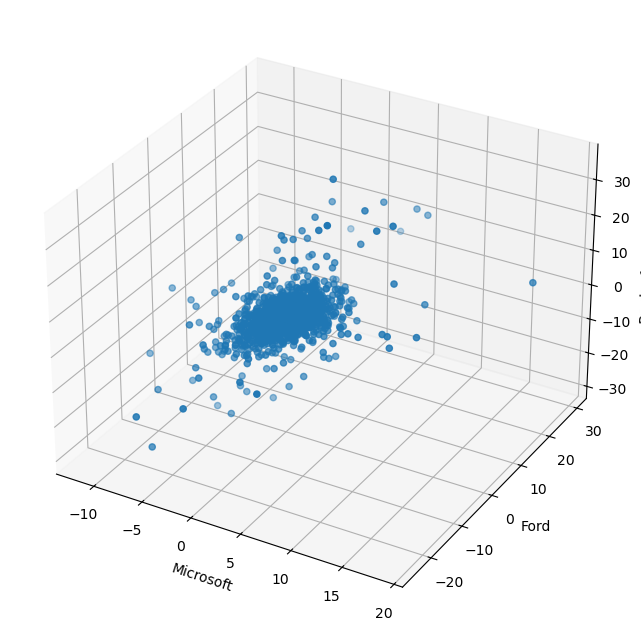

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')  # Specify the projection here

# Assuming delta is a DataFrame with columns 'MSFT', 'F', 'BAC'
ax.scatter(delta['MSFT'], delta['F'], delta['BAC'])
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')

plt.show()


Let's assume that the data follows a multivariate (i.e. multidimensional) Gaussian distribution. Such a probability distribution can be characterised by two statistics: the mean and covariance matrix of the 3-dimensional data. 

The Mahalanobis distance is a measure of the distance between a point and a distribution. Unlike the Euclidean distance, which is scale-dependent, the Mahalanobis distance accounts for the variance of each variable and the covariance between variables, making it scale-invariant. This is particularly useful in multivariate anomaly detection where the variables have different units or scales, as in your stock price change example.

We can then compute the mean and covariance matrix of the 3-dimensional 'delta' data (which represent the percentage of changes in the daily closing price of each stock). Then, as a distance measure, to determine the anomalous trading days, we can compute the **Mahalanobis distance** (to be more precise, the square of the Mahalanobis distance) between the percentage of price change on each day against the mean percentage of price change:
\begin{equation}
\textrm{MDist}(x,\bar{x}) = (x - \bar{x})^T S^{-1}(x - \bar{x})
\end{equation}
where $x$ is assumed to be a row vector, $\bar{x}$ denotes the mean vector, and $S$ denotes the covariance matrix of the data.

See Section 12.3 in the "Data Mining: Concepts and Techniques" book for more information on the Mahalanobis distance. As a first step, we can define a function for the Mahalanobis distance:

In [4]:
from numpy.linalg import inv

def mahalanobis(x=None, data=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    """
    x_mu = x - np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.matmul(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

Then, we can call the created function for the Mahalanobis distance on the 'delta' dataframe containing the daily percentage changes for each stock:

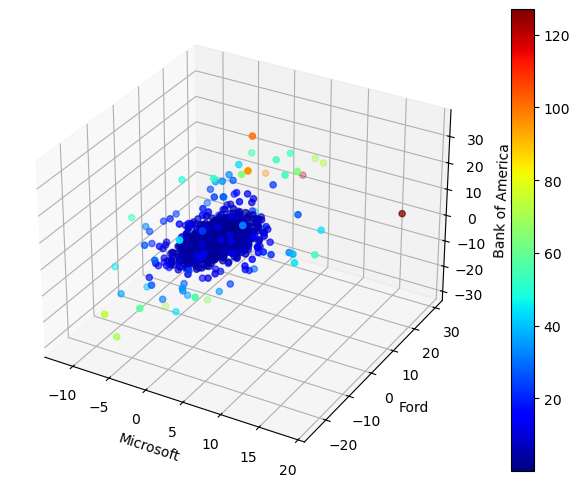

In [5]:
# Compute Mahalanobis distance for delta dataset
mahal = mahalanobis(x=delta, data=delta[['MSFT', 'F', 'BAC']])

# Assign an outlier score for the data based on the computed Mahalanobis distance
outlier_score = mahal

# Display 3D scatterplot with datapoints having a different color according to their outlier score
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=outlier_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The top outliers are shown as the dark red and orange points in the above scatterplot. We can examine the dates associated with the top-5 highest outlier scores as follows:

In [6]:
outlier = pd.DataFrame(outlier_score, index=delta.index, columns=['Outlier score'])
result = pd.concat((delta,outlier), axis=1)
result.nlargest(5,'Outlier score')

,MSFT,F,BAC,Outlier score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,127.047494
11/26/2008,2.501251,29.518072,4.256757,121.521343
4/9/2009,2.501297,7.341772,35.269122,100.373287
11/28/2008,-1.317721,25.116279,5.314323,98.253689
1/21/2009,4.870124,-1.877934,30.980392,95.492852


We see for example that the top outlier was detected for 13th October 2008. This was a period of economic instability due to the 2008 global financial crisis (https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008).

We can subsequently inspect stocks around the top-2 outlier dates for each company, and see to which compani(es) are these outliers attributed to.

Text(0, 0.5, 'Percent Change')

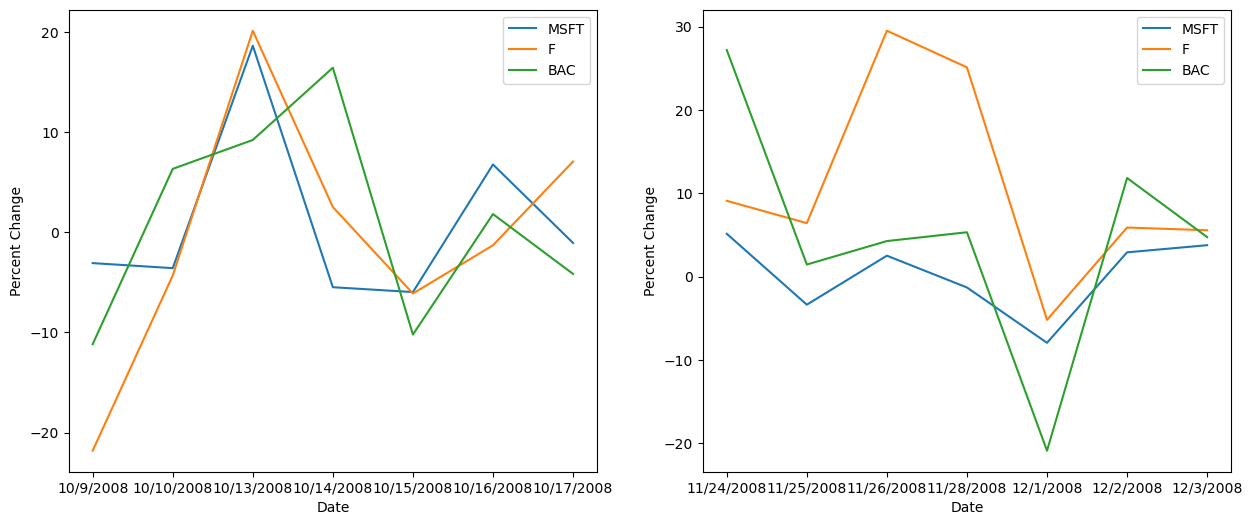

In [7]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts = delta[445:452]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta[477:484]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

## 2. Outlier detection using proximity-based approaches

Proximity-based outlier detection is a non-parametric method that relies on the spatial relationships between data points. It does not assume any specific distribution for the data. Techniques like the k-nearest neighbor (k-NN) are used, where the distance of a point to its k-th nearest neighbor is calculated. Points that have a large distance to their k-th nearest neighbor are considered outliers. This approach is particularly useful in detecting outliers in datasets where the data doesn’t conform to a known distribution or is multidimensional.

The k-nearest neighbors (k-NN) method in outlier detection involves calculating the distance of a point from its nearest neighbors. Points that have a significantly larger distance from their neighbors compared to the rest of the data are marked as outliers. This method is versatile and can be used in various types of data, but it can be computationally intensive, especially with large datasets.

This is a model-free outlier detection approach as it does not require constructing an explicit model of the normal class to determine the outlier score of data instances. The example code shown below employs the k-nearest neighbor approach to calculate the outlier score. Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbour whereas an outlier is likely to have a large distance to its k-th nearest neighbour. In the example below, we apply the distance-based approach with k=4 to identify the anomalous trading days from the stock market data described in the previous section.

For more information on the NearestNeighbors() function please see the scikit learn documnetation: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html




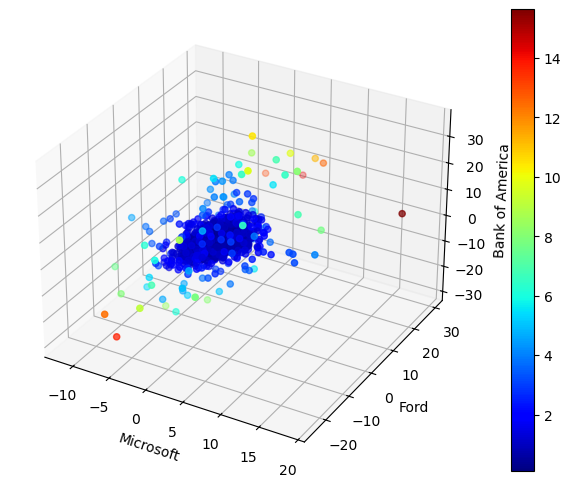

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

# Implement a k-nearest neighbour approach using k=4 neighbours
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.values)
distances, indices = nbrs.kneighbors(delta.values)

# The outlier score is set as the distance between the point and its k-th nearest neighbour
outlier_score = distances[:,knn-1]

# Plot 3D scatterplot of outlier scores
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=outlier_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The results are slightly different than the one shown in Section 1 due to the difference distance used (Euclidean distance vs Mahalanobis distance) and the proximity criterion to detect the outliers. 

We can examine the dates associated with the top-5 highest outlier scores as follows. 

In [9]:
outlier = pd.DataFrame(outlier_score, index=delta.index, columns=['Outlier score'])
result = pd.concat((delta,outlier), axis=1)
result.nlargest(5,'Outlier score')

,MSFT,F,BAC,Outlier score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,15.642827
11/26/2008,2.501251,29.518072,4.256757,14.212749
10/7/2008,-6.744279,-20.867209,-26.225949,13.751302
11/28/2008,-1.317721,25.116279,5.314323,13.139586
9/30/2008,6.717317,24.700240,15.702479,12.599739


Finally, similarly to what was carried out in Section 1, we can inspect stocks around those outlier dates for each company. The below figure inspects the delta values for each company around the date of the 3rd detected outlier, on 7th October 2008, which represents a key date for the 2008 financial resession with large drops in stock values. Two companies seem to be primarily responsible for the creation of this outlier.

Text(0, 0.5, 'Percent Change')

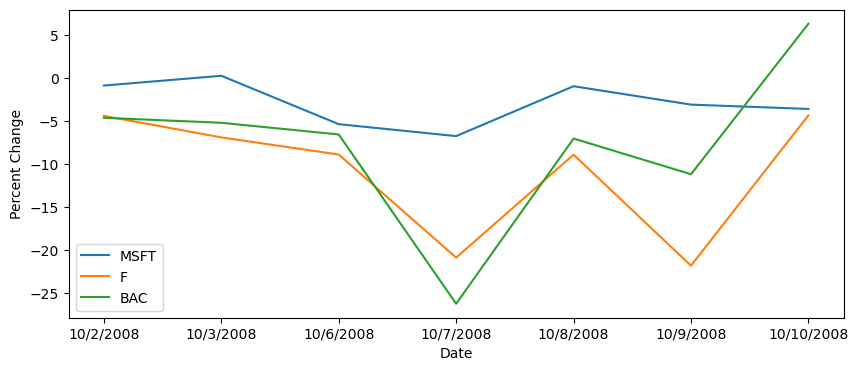

In [10]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta[440:447]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

## 3. Outlier detection using classification-based methods

Classification-based outlier detection, specifically using One-Class SVM, is a method where the classifier is trained only on the 'normal' data. It constructs a model that defines a boundary around this normal data, and any data point falling outside this boundary is considered an outlier. This method is effective when you have a dataset predominantly consisting of 'normal' data and want to identify the rare items that do not fit this pattern. It's particularly useful in scenarios where outliers are not well-represented in the dataset.

The **support vector machine (SVM)** algorithm developed initially for binary classification can be used for one-class classification, and therefore for outlier detection using a classification-based method where we construct a classifier to describe only the normal class.

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as **One-Class SVM**. One-Class SVM is a variant of the Support Vector Machine used for outlier detection in datasets where the majority of the data represents 'normal' conditions. It learns the boundaries of these normal points and is able to classify any point lying outside this boundary as an outlier. This method is particularly effective in high-dimensional spaces and where the data doesn’t follow a specific distribution.

In this section, we will work with a different dataset on house prices available at: https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv . This dataset has 13 input variables that describe the properties of the house and suburb and requires the prediction of the median value of houses in the suburb in thousands of dollars. Information and metadata about the dataset can be found at: https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.names . Please spend some time to inspect the dataset and its metadata.

As a first step, we load the dataset and split it into input and output (target) elements:

In [11]:
from pandas import read_csv

# Loading the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(url, header=None)

# Extracting the values from the dataframe
data = df.values

# Split dataset into input and output elements
X, y = data[:, :-1], data[:, -1]

# Summarize the shape of the dataset
print(X.shape, y.shape)

(506, 13) (506,)


Using the OneClassSVM() function in scikit-learn, we can initialise and train an one-class SVM classifier on the input data. Please study the [OneClassSVM() documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) for information on input arguments. 

We can then print the estimated labels, which for each object are -1 for outliers and 1 for inliers (i.e. data points that are considered normal).

In [12]:
from sklearn.svm import OneClassSVM

ee = OneClassSVM(nu=0.01,gamma='auto')
yhat = ee.fit_predict(X) # Perform fit on input data and returns labels for that input data.

print(yhat) # Print labels: -1 for outliers and 1 for inliers.

[-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1
  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1  1
 -1 -1 -1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1 -1
 -1  1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1
  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1  1 -1
 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1 -1  1 -1  1  1 -1 -1 -1
  1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1
 -1  1 -1 -1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1

Having trained the one-class SVM, we can then select all rows from the dataset that are **not** outliers:

In [13]:
# Select all rows that are not outliers
mask = yhat != -1
X, y = X[mask, :], y[mask]

# Summarize the shape of the updated dataset
print(X.shape, y.shape)

(190, 13) (190,)


As we see, the new dataset has a significantly smaller number of objects, all of which are considered by the one-class SVM to be `inliers', i.e. to belong to the normal distribution of the data.